## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single hashtag
* "➋" represents a single URL
* "➌" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
hashtags_pattern = re.compile(r'(\#[a-zA-Z0-9]+)')

In [4]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [5]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 75% English words
#### Also, make the mentions of usernames, URLs, and hashtags generic

In [10]:
def load_data(filename, threshold=0.33):
    data = [(hashtags_pattern.sub("➊", 
             urls_pattern.sub("➋", 
             at_mentions_pattern.sub("➌", 
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

In [14]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

#### Show examples

In [15]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
people distancing themselves from me always seem to make me feel sad


In [16]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
It is, evidently, ➊.

Yes, I have siblings. Three, actually.

No, they're not on twitter.

No, I'm not posting a photo.

No, I'm not wishing them a "Happy National Siblings Day."

What a silly concept.


#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11202


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames, URLs, and hashtags, as well as common English first names

In [24]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [25]:
generic_tokens = {"➊", "➋", "➌"}

In [26]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [27]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [28]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [29]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7080    0.6811    0.6943      1082
    subtweet     0.7125    0.7377    0.7249      1159

 avg / total     0.7103    0.7104    0.7101      2241

Test Data Accuracy: 0.7104

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9846    0.9796    0.9821     10120
    subtweet     0.9796    0.9846    0.9821     10043

 avg / total     0.9821    0.9821    0.9821     20163

Train Data Accuracy: 0.9821

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7146    0.6637    0.6882      1109
    subtweet     0.6920    0.7403    0.7153      1132

 avg / total     0.7032    0.7024    0.7019      2241

Test Data Accuracy: 0.7024

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9851    0.9785    0.9818     10093
    subtweet     0.9786    0.9852    0.9819     10070



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [30]:
def most_informative_features(pipeline, n=10000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [31]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 2.34 s, sys: 59.5 ms, total: 2.4 s
Wall time: 2.59 s


In [32]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [33]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [34]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(25)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! &,-12.9695,.,-7.5149
1,! ! ),-12.9695,",",-7.8807
2,! ! -,-12.9695,"""",-8.0400
3,! ! /,-12.9695,people,-8.3247
4,! ! 0.125,-12.9695,?,-8.3881
5,! ! 11,-12.9695,like,-8.5629
6,! ! 3,-12.9695,don't,-8.5688
7,! ! 5,-12.9695,just,-8.6124
8,! ! 5/10,-12.9695,i'm,-8.7010
9,! ! 6,-12.9695,!,-8.7257


#### Define function for visualizing confusion matrices

In [35]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

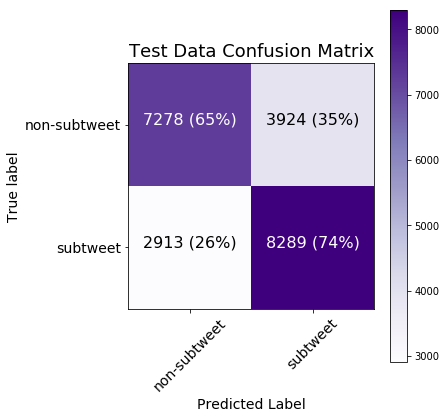

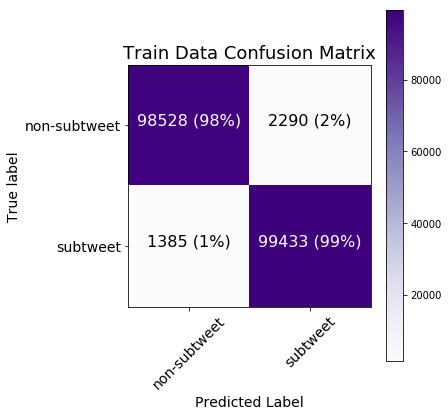

In [36]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [37]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [38]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [39]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(hashtags_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [40]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [41]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 9.33 s, sys: 156 ms, total: 9.49 s
Wall time: 9.82 s


#### Show a random table

In [42]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
66,tfw you are on twitter to wryly complain about the insomnia that was largely caused by being on twitter,2018-01-12 03:29:13,7,1,951732786557341698,0.8513
481,"Twitter contrived to have people pretend to ""like"" you and now it reveals how many people could've pretended to like you but chose not to.",2015-11-11 15:56:31,0,0,664547274110967808,0.8360
270,"It's cool that we get to do cool stuff like this (and that we can make ""cool"" mean whatever we friggin please)➋",2016-09-05 14:33:54,2,0,772865356922810368,0.8048
163,"""What if Iago isn't a devilish mastermind, but just, like, a shitty dude? Like a petty, shitty dude?""- my bathetic pedagogy in a nutshell",2017-04-20 12:02:04,18,3,855089189423120384,0.7860
43,Deep down I am very dumb and immature and it is very very exhausting to pretend otherwise all day gang,2018-02-19 21:48:33,24,2,965780184283668480,0.7843


#### Prepare statistics on tweets

In [43]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [44]:
test_df_stats = tests_df.describe()

In [45]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [46]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5130,0.5162,0.5523,0.5267,0.5218,0.5008,0.4447,0.5427,0.5207,0.4458,0.5396,0.5078,0.5458,0.5427
std,0.1112,0.1177,0.1180,0.1148,0.1095,0.1172,0.1012,0.1230,0.1130,0.1027,0.1220,0.1188,0.1216,0.1098
min,0.1886,0.0941,0.1360,0.1435,0.1375,0.0440,0.1518,0.1681,0.1153,0.1234,0.0684,0.0467,0.1654,0.0807
25%,0.4355,0.4319,0.4731,0.4526,0.4481,0.4257,0.3777,0.4644,0.4454,0.3770,0.4619,0.4310,0.4668,0.4770
50%,0.5174,0.5141,0.5508,0.5235,0.5239,0.5002,0.4497,0.5353,0.5186,0.4562,0.5374,0.5024,0.5471,0.5421
75%,0.5917,0.5926,0.6352,0.6013,0.5926,0.5749,0.5062,0.6247,0.5903,0.5037,0.6192,0.5847,0.6300,0.6123
max,0.8513,0.8828,0.8769,0.9016,0.9263,0.8808,0.8095,0.8645,0.8827,0.7802,0.8743,0.8720,0.8449,0.8576


#### Plot a histogram with three random users

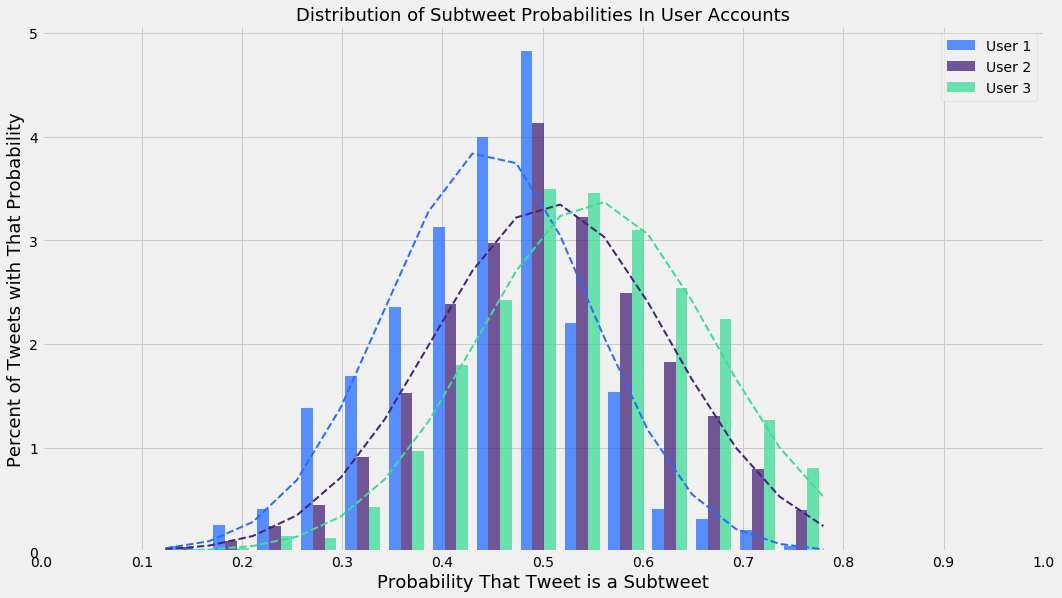

In [47]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [48]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [49]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5182
std,0.1171
min,0.0440
25%,0.4405
50%,0.5147
75%,0.5939
max,0.9263


#### Now plot

No handles with labels found to put in legend.


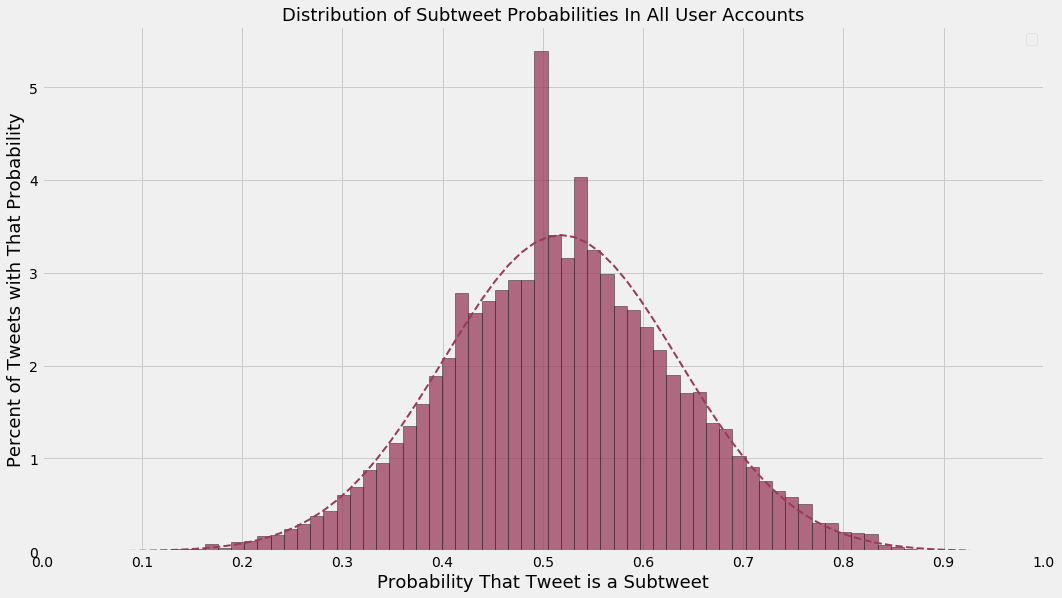

In [50]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [51]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [52]:
length_data = [len(tweet) for tweet in training_data]

In [53]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [54]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [55]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [56]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [57]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
16877,293,That's what gets me WHY low Brow him ?? Why By all that's right he should be impeachedhe is still involves himself in business foreignCabinet heads are just as slimy with using planes etc his disregard for bills Pres o put in 4 protecting us!!
12086,293,Again.. you worship a xenophobic God and a Bible that promotes hate as long as you don't ignore all those parts.. a God that sends people to burn in Hell forever for not believing in him....you don't get to call those talking with you haters!
12591,281,"Guys, I'm gonna be completely transparent with you. I've enjoyed the weeks The Flash was off the air. Mainly because this season.... This season 4 curse. It feels almost just like Arrow S4 years ago. But instead of Olicity shippers, these new hardcore ""fans"" accusing urs truly of"
17346,281,"If it turns out Joy Reid is falsely denying authorship of these horribly bigoted articles & fabricated a tale about nefarious hackers invading the Wayback Archives to add these passages to her real articles, what should happen? What will happen? Do any liberals care if it's true?"
20810,281,"Same treatment Dolph, Ye, and Gucci got, imprisonment or ""rehabilitation"" and stripping that person of their essence psychologically which changes their effect on culture and what they say which leads to a shell of obedience it's deeper than that but in essence that's not Rahmeek"


#### Top 5 shortest tweets

In [58]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
1894,4,Rude
2045,4,Ugly
4801,4,Fake
8630,4,Lame
11973,4,fear


#### Tweet length statistics

In [59]:
length_data_for_stats.describe()

,Length
count,22404.0000
mean,103.3253
std,72.8493
min,4.0000
25%,46.0000
50%,83.0000
75%,144.0000
max,293.0000


#### Punctuation

In [60]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [61]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [62]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
4170,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
15008,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
20984,10,"Hooray—for those of you who've been asking when FLASHBACK will be available for pre-order on *ebook* the answer is finally: NOW! Alas, pre-ordering won't make it come out sooner than 11/6 (still writing it, guys). BUT, it does make me super happy, so… 😉\n"
14929,10,"USA's share of global GDP was about 50% after WW2, today it is about 15%. It will further decline this century (although its economy & GDP/capita will continue to grow in absolute terms).\n\nHow will America react to this loss of ""relative power""? By all indications, rather badly."
13069,10,I created an equation to find the largest meaningful number in the observable universe.\n\nVolume Quantitative Infinity [vQ(inf)]= (4/3)(pi)ct^3\n\nI'll explain it in a thread. (1/?)


#### Tweets punctuation statistics

In [63]:
punctuation_data_for_stats.describe()

,Punctuation
count,22404.0000
mean,1.8818
std,1.5584
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [64]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [65]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [66]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,"Ended up going 3-2, proudest moment was taking two rounds against one of the better players in the community who plays Twintelle. \nHe beat the shit out of me in casuals, but I think I surprised him with that last match. \nI probably should start playing this game 😂"
12678,8,"A Fascist Canadian dictator, who lied just to get in power and is now trying hard to remain forever by silencing all criticism😡👏, will he succeed?🤔: Trudeau's Increasingly Dictatorial Attitude Shows The Danger Of Centralized Power via"
12646,8,My media tab is filled with so many gifs it's giving me anxiety
12650,8,Everything is coming together and I'm so excited 😍❤️
12651,8,"unbelievable, kim shin yeong my favorite model"


#### Top 5 tweets with fewest stop words

In [67]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
22249,0,When ?
2140,0,Fuck...
21625,0,well.....
5759,0,We been knew
3222,0,fuck


#### Tweets stop words statistics

In [68]:
stop_words_data_for_stats.describe()

,Stop words
count,22404.0000
mean,7.1113
std,1.3291
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [69]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [70]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [71]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [72]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [73]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
13473,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
8660,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
7329,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",57
1177,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57
16213,"If you live in Arizona, tell me everything good about it... Please and thank you 😁👌🏽\n\nAlso does anybody know any wavy ass barbershops or dope tattoo artists or ppl who are just nice kuz we wanna make friends out here tbh. I want a basic ""how to"" of AZ so teach me shit.",57


#### Top 5 tweets with fewest unique words

In [74]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
1758,CORNY,1
18453,Yes yes yes yes yes yes,1
14582,Same same,1
8990,cool,1
22125,help,1


#### Tweets unique words statistics

In [75]:
unique_words_data_for_stats.describe()

,Unique words
count,22404.0000
mean,18.7121
std,11.8161
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

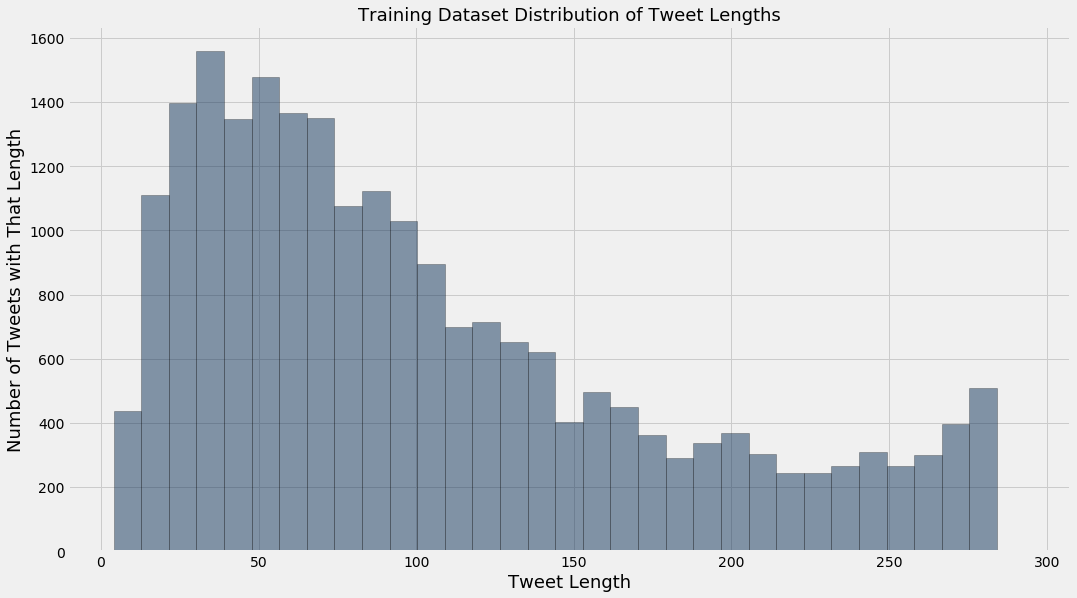

In [76]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

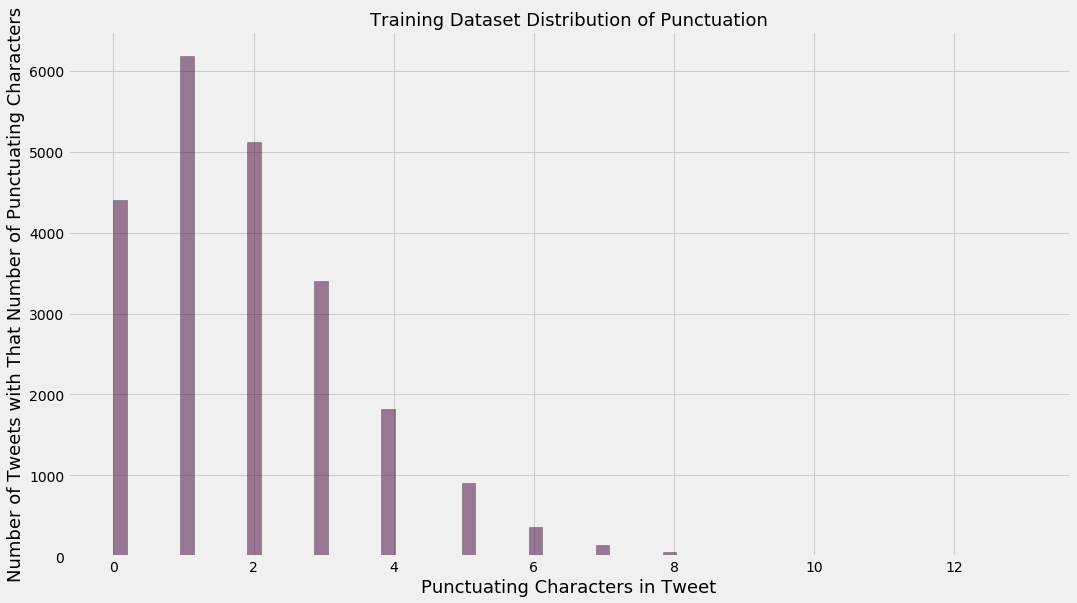

In [77]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

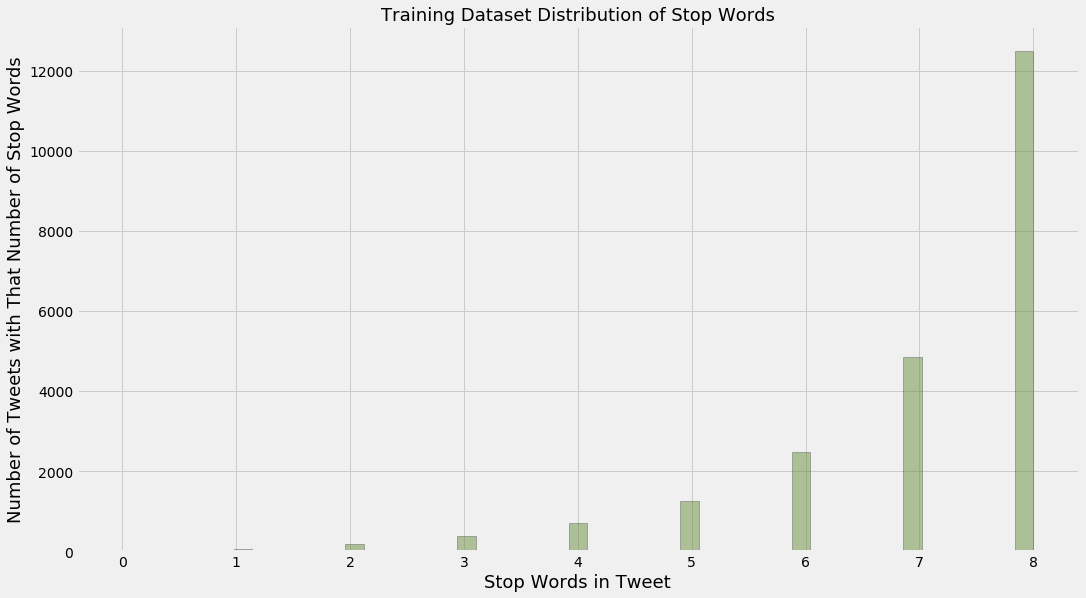

In [78]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

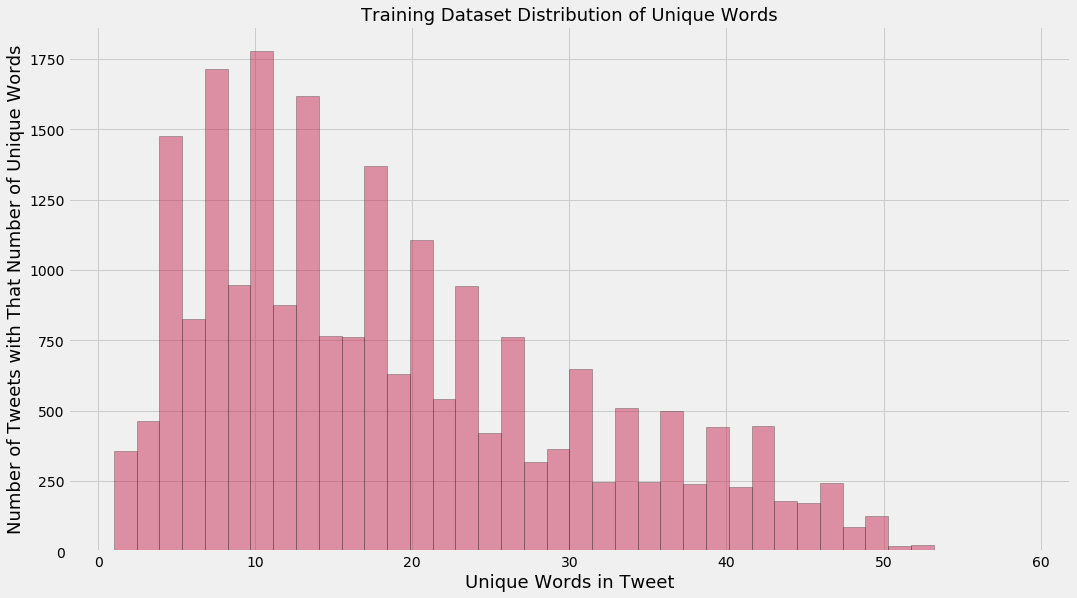

In [79]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()